# Figure 8 & 9. The overlap between splice isoforms identified in the 5'-adapter captured ONT sequencing and the reference annotations.

Code for making Figures 8 & 9 in the Nanopore DRS paper *Native long-read RNA sequencing of the Arabidopsis thaliana transcriptome*. For this figure we're focussing on the full-length splice isoforms identified from the two WT col-0 tissue datasets that were sequenced using the 5' adapter ONT Direct RNA Sequencing protocol, and comparing this with the annotation.

Here we're just focussing on splicing isoforms, so full-length molecules with different 5' and 3' end sites, and different poly-A tail lengths, are treated as the same isoform as long as their splicing pattern is the same.

*Note: pyupset requires a specific install of python, so make sure this notebook is running in the right conda env*

In [34]:
import re, os, sys, pysam, json, matplotlib, numpy, time
%matplotlib inline
import matplotlib.pyplot as plt
from snakemake.io import expand
from Bio import SeqIO
import pyupset as pyu
import pandas as pd
matplotlib.__version__

'2.0.2'

In [35]:
# Datasets
import os, re
json_files = {"col0_5padapter_rep1":{"jsonfile":"201902_col0_2916_5adapter_exp2.passes.splice_stats.json",
                                     "path":"../../datasets/ONT_DRS/01_5p_WT_Col0_2916/splicing/"},
              "col0_5padapter_rep2":{"jsonfile":"201902_col0_2918_5adapter.passes.splice_stats.json",
                                     "path":"../../datasets/ONT_DRS/03_5p_WT_Col0_2918/splicing/"}}

minION_datasets=[]
for keystr in json_files.keys():
    fullpath = os.path.join(json_files[keystr]["path"],
                            json_files[keystr]["jsonfile"])
    minION_datasets.append(fullpath)

json_files = {"col0_5padapter_rep1":{"jsonfile":"201902_col0_2916_5adapter_exp2.error_corrected.passes.splice_stats.json",
                                     "path":"../../datasets/Error_Corrected_ONT_DRS/01_5p_WT_Col0_2916/splicing/"},
              "col0_5padapter_rep2":{"jsonfile":"201902_col0_2918_5adapter.error_corrected.passes.splice_stats.json",
                                     "path":"../../datasets/Error_Corrected_ONT_DRS/03_5p_WT_Col0_2918/splicing/"}}

ec_minION_datasets=[]
for keystr in json_files.keys():
    fullpath = os.path.join(json_files[keystr]["path"],
                            json_files[keystr]["jsonfile"])
    ec_minION_datasets.append(fullpath)

In [36]:
def refactorToLinkedSplices(jsondatasets, collapse_splicesets=False, nrep=10000):

    read_dic={}
    for splicejson in jsondatasets:
        print("Processing read-level splicing details from {}...".format(splicejson))
        i=0
        nc=1
        t0=time.time()
        read_dic={}
        these_splices = json.load(open(splicejson,"r"))
        for splice in these_splices.keys():
            for read in these_splices[splice]['reads']:
                try:
                    read_dic[read].append(splice)
                except KeyError:
                    read_dic[read] = [splice]
            if i==nrep:
                print("\tprocessed {} splices in {:.2f}s".format(nc*nrep, time.time()-t0))
                i=0
                nc+=1
                t0=time.time()
            i+=1
    
    print("Parsing unique splicing patterns from read-level information...")
    i=0
    nc=1
    t0=time.time()
    linkedsplice_dict = {}
    for read in read_dic.keys():
        try:
            linkedsplice_dict[tuple(read_dic[read])]["reads"].append(read)
        except KeyError:
            linkedsplice_dict[tuple(read_dic[read])]={"reads":[read],
                                                      "splices":{}}
            for splice in read_dic[read]:
                linkedsplice_dict[tuple(read_dic[read])]["splices"][splice] = these_splices[splice]
        if i==nrep:
            print("processed {} reads in {:.2f}s".format(nc*nrep, time.time()-t0))
            i=0
            nc+=1
            t0=time.time()
        i+=1
    
    if collapse_splicesets:
        print("Collapsing perfect linked-splicing subsets...")
        ssplices = numpy.array(sorted(linkedsplice_dict.keys(), key=len))
        pc=0
        nc=1
        t0=time.time()
        i=0
        delsplices=[]
        while i<len(ssplices):
            thisspliceset = ssplices[i]
            subset_comp = [set(thisspliceset).issubset(set(x)) for x in ssplices[i+1:]]
            subsets = numpy.where(subset_comp)[0]
            subset_splices = ssplices[i+1:][subsets]
            if len(subset_splices)>0:
                thissplicereads = linkedsplice_dict[thisspliceset]['reads']
                #print("qsplice reads: ", len(thissplicereads))
                for splice in subset_splices:
                    #print("tsplice reads before: ", len(linkedsplice_dict[ssplices[entry]]['reads']))
                    linkedsplice_dict[splice]['reads'] = list(set(linkedsplice_dict[splice]['reads']+thissplicereads))
                    #print("tsplice reads after: ", len(linkedsplice_dict[ssplices[entry]]['reads']))
                delsplices.append(thisspliceset)
                del linkedsplice_dict[thisspliceset]
            if pc==nrep:
                print("processed {} linked splice sets in {:.2f}s".format(nc*nrep, time.time()-t0))
                pc=0
                nc+=1
                t0=time.time()
            pc+=1
            i+=1
    
    return(linkedsplice_dict)

In [37]:
drsds_unique_spliceiso={}
for dataset in minION_datasets:
    drsds_unique_spliceiso[dataset] = refactorToLinkedSplices([dataset])

drs_unique_spliceiso = refactorToLinkedSplices(minION_datasets)

Processing read-level splicing details from ../../datasets/ONT_DRS/01_5p_WT_Col0_2916/splicing/201902_col0_2916_5adapter_exp2.passes.splice_stats.json...
	processed 10000 splices in 0.98s
	processed 20000 splices in 0.03s
	processed 30000 splices in 0.03s
	processed 40000 splices in 0.03s
	processed 50000 splices in 0.03s
Parsing unique splicing patterns from read-level information...
processed 10000 reads in 0.01s
processed 20000 reads in 0.01s
processed 30000 reads in 0.01s
processed 40000 reads in 0.01s
processed 50000 reads in 0.01s
processed 60000 reads in 0.01s
processed 70000 reads in 0.01s
processed 80000 reads in 0.01s
processed 90000 reads in 0.01s
processed 100000 reads in 0.01s
processed 110000 reads in 0.01s
processed 120000 reads in 0.01s
processed 130000 reads in 0.01s
processed 140000 reads in 0.01s
Processing read-level splicing details from ../../datasets/ONT_DRS/03_5p_WT_Col0_2918/splicing/201902_col0_2918_5adapter.passes.splice_stats.json...
	processed 10000 splices

In [38]:
ec_drsds_unique_spliceiso={}
for dataset in ec_minION_datasets:
    ec_drsds_unique_spliceiso[dataset] = refactorToLinkedSplices([dataset])

ec_drs_unique_splicesiso = refactorToLinkedSplices(ec_minION_datasets)

Processing read-level splicing details from ../../datasets/Error_Corrected_ONT_DRS/01_5p_WT_Col0_2916/splicing/201902_col0_2916_5adapter_exp2.error_corrected.passes.splice_stats.json...
	processed 10000 splices in 0.82s
	processed 20000 splices in 0.03s
	processed 30000 splices in 0.04s
	processed 40000 splices in 0.04s
Parsing unique splicing patterns from read-level information...
processed 10000 reads in 0.01s
processed 20000 reads in 0.01s
processed 30000 reads in 0.01s
processed 40000 reads in 0.01s
processed 50000 reads in 0.01s
processed 60000 reads in 0.01s
processed 70000 reads in 0.01s
processed 80000 reads in 0.01s
processed 90000 reads in 0.01s
processed 100000 reads in 0.01s
processed 110000 reads in 0.01s
processed 120000 reads in 0.01s
processed 130000 reads in 0.01s
processed 140000 reads in 0.01s
processed 150000 reads in 0.01s
processed 160000 reads in 0.01s
Processing read-level splicing details from ../../datasets/Error_Corrected_ONT_DRS/03_5p_WT_Col0_2918/splicing/

OK so I want to compare these sets of unique splicing patters with each other and with the splicing patters from both the araport 11 and AtRTD2 annotation. So now I need to load the annotation, parse out the splicing patterns...

In [39]:
# load the genome
genome = {}
for seq_record in SeqIO.parse("../../supporting_datasets/TAIR10_genome/Arabidopsis_thaliana.TAIR10.dna.toplevel.fa", "fasta"):
    genome[seq_record.name] = seq_record

In [40]:
from parsing_routines.gff_gtf_tools import annotation
from parsing_routines.general_classes_and_functions import computeIntrons

def getAnnotationLinkedIntrons(annot, genome, chr_synonym_dic={}, parent_key="parent",
                         LOG_EVERY_N=10000):
    
    """ return a dictionary with all the introns in a given annotation """
    
    annot.clear_all()
    annot.set_feature("exons")
    exons = annot.get_selection()
    tx_exons={}
    for exon in exons:
        if type(exon.desc[parent_key]) is list:
            for parent in exon.desc[parent_key]:
                try:
                    tx_exons[parent].append(exon)
                except KeyError:
                    tx_exons[parent]=[exon]
        else:
            try:
                tx_exons[exon.desc[parent_key]].append(exon)
            except KeyError:
                tx_exons[exon.desc[parent_key]]=[exon]
    
    splice_details={}
    nlogs=1
    counter=0
    for transcript in tx_exons.keys():
        keystr = []
        these_introns = computeIntrons(tx_exons[transcript], parent_key=parent_key, logger=None)
        if len(these_introns)>0:
            for intron in these_introns:
                keystr.append("{}:{}-{}".format(intron.chrid,intron.start-1,intron.stop))

            keystr=tuple(keystr)
            if keystr in splice_details.keys():
                splice_details[keystr]["transcripts"].append(transcript)
            else:
                sites=[]
                is_canonical=[]
                for intron in these_introns:
                    donor_splice_site=None
                    acceptor_splice_site=None

                    this_chrid = intron.chrid
                    if intron.chrid not in genome.keys():
                        if intron.chrid in chr_synonym_dic.keys() and chr_synonym_dic[intron.chrid] in genome.keys():
                            this_chrid = chr_synonym_dic[intron.chrid]
                        else:
                            msg = "There is a mismatch between the annotation and " \
                                  "genome chromosome IDs that is not accounted for " \
                                  "in the provided chromosome synonyms list. Details: " \
                                  "Annotation ID: {}, genome IDs: {}, synonyms: {} " \
                                  "".format(intron.chrid, genome.keys(), chr_synonym_dic)
                            raise ValueError(msg)

                    if intron.strand=="-":
                        donor_splice_site = genome[this_chrid][intron.stop-2:intron.stop].reverse_complement()
                        acceptor_splice_site = genome[this_chrid][intron.start-1:intron.start+1].reverse_complement()
                    else:
                        acceptor_splice_site = genome[this_chrid][intron.stop-2:intron.stop]
                        donor_splice_site = genome[this_chrid][intron.start-1:intron.start+1]
                    sites.append((str(donor_splice_site.seq), str(acceptor_splice_site.seq)))
                    if donor_splice_site.seq!="GT" or acceptor_splice_site.seq!="AG":
                        is_canonical.append(False)
                    else:
                        is_canonical.append(True)

                splice_details[keystr]={"transcripts":[transcript],
                                        "sites":sites,
                                        "is_canonical":is_canonical}
        
        counter+=1
        if (counter % LOG_EVERY_N)==0:
            msg="processed {these} transcripts...".format(these=(nlogs*LOG_EVERY_N))
            print(msg)
            nlogs+=1
    
    return(splice_details)

In [10]:
a11_path = "../../annotations/Araport/Araport11_GFF3_genes_transposons.201606.gtf"
# load the Araport 11 annotation
a11 = annotation(a11_path, filetype="gtf", stripChr=True)
chr_synonym_dic = {"C":"Pt","M":"Mt"}
a11_introns = getAnnotationLinkedIntrons(a11, genome, chr_synonym_dic, 'transcript_id')

processed 10000 transcripts...
processed 20000 transcripts...
processed 30000 transcripts...
processed 40000 transcripts...
processed 50000 transcripts...


In [11]:
maxsplices = 0
maxtx=0
maxtxkey=None
for key in a11_introns.keys():
    if len(key)>maxsplices:
        maxsplices=len(key)
    if len(a11_introns[key]["transcripts"])>maxtx:
        maxtx=len(a11_introns[key]["transcripts"])
        maxtxkey=key
        print(key, len(a11_introns[key]["transcripts"]))
print(maxsplices, maxtx)

('1:3913-3995', '1:4276-4485', '1:4605-4705', '1:5095-5173', '1:5326-5438') 1
('1:83671-83883',) 2
('1:472507-472667',) 3
('1:10328285-10328884',) 4
('5:15562514-15562606',) 5
78 5


In [12]:
print(maxtxkey, ", ".join(a11_introns[maxtxkey]["transcripts"]))

('5:15562514-15562606',) AT5G38865.1, AT5G38865.2, AT5G38865.3, AT5G38865.4, AT5G38865.5


In [13]:
# load the AtRTD2 annotation
atrtd2 = annotation("../../annotations/AtRTD/AtRTD2_19April2016.gtf", filetype="gtf", stripChr=True)
atrtd2_introns = getAnnotationLinkedIntrons(atrtd2, genome, chr_synonym_dic, "transcript_id")

processed 10000 transcripts...
processed 20000 transcripts...
processed 30000 transcripts...
processed 40000 transcripts...
processed 50000 transcripts...
processed 60000 transcripts...
processed 70000 transcripts...
processed 80000 transcripts...


In [14]:
maxsplices = 0
maxtx=0
maxtxkey=None
for key in atrtd2_introns.keys():
    if len(key)>maxsplices:
        maxsplices=len(key)
    if len(atrtd2_introns[key]["transcripts"])>maxtx:
        maxtx=len(atrtd2_introns[key]["transcripts"])
        maxtxkey=key
        print(key, len(atrtd2_introns[key]["transcripts"]))
print(maxsplices, maxtx)

('1:3913-3995', '1:4276-4485', '1:4605-4705', '1:5095-5173', '1:5326-5438') 1
('1:10135988-10136184',) 2
78 2


In [15]:
print(maxtxkey, ", ".join(atrtd2_introns[maxtxkey]["transcripts"]))

('1:10135988-10136184',) AT1G29041.1, AT1G29041_P1


# Plotting the data

OK, lets plot some of the unique splicing data, starting with how many unique splices are present in each dataset and/or annotation...


ONT DRS 5' adapter dataset unique splice counts:
	DRS col0 01 5p:   22366
	DRS col0 03 5p:   32353

Annotation unique splice counts:
	Araport 11:   43681
	AtRTD2:   70202

ONT DRS 5' adapter dataset unique splice counts:
	EC DRS col0 01 5p:   13014
	EC DRS col0 03 5p:   17848

Annotation unique splice counts:
	Araport 11:   43681
	AtRTD2:   70202


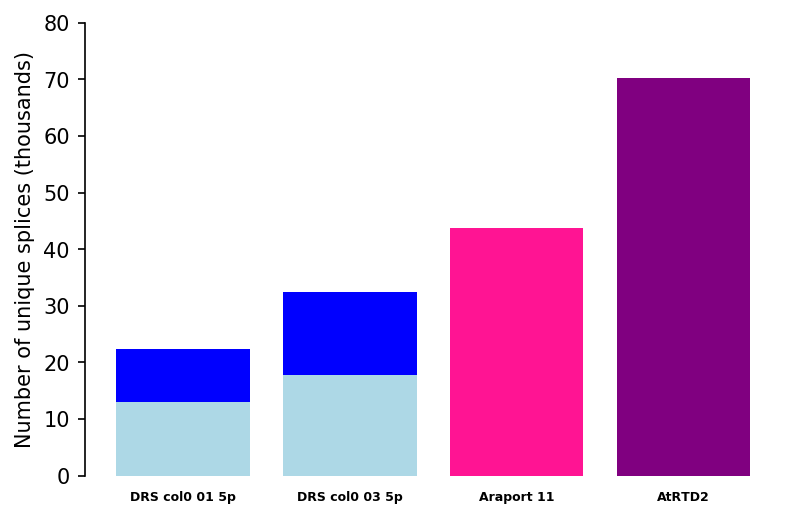

In [76]:
# plot the total splicing complement in each annotation and data file
def addOrig5pDRS(plotarrays, col="blue"):
    print("\nONT DRS 5' adapter dataset unique splice counts:")
    dsordering=drsds_unique_spliceiso.keys()
    for dataset in dsordering:
        datasetname = "DRS col0 {:02d} 5p".format(int(re.match(".+col0_([0-9]+)_.+", dataset).group(1))-2915)
        print("\t{:>5}:{:>8d}".format(datasetname, len(drsds_unique_spliceiso[dataset])))
        plotarrays[0].append(datasetname)
        plotarrays[1].append(len(drsds_unique_spliceiso[dataset]))
        plotarrays[2].append(col)
    return(plotarrays)

def addEC5pDRS(plotarrays, col="lightblue"):
    print("\nONT DRS 5' adapter dataset unique splice counts:")
    dsordering=ec_drsds_unique_spliceiso.keys()
    for dataset in dsordering:
        datasetname = "EC DRS col0 {:02d} 5p".format(int(re.match(".+col0_([0-9]+)_.+", dataset).group(1))-2915)
        print("\t{:>5}:{:>8d}".format(datasetname, len(ec_drsds_unique_spliceiso[dataset])))
        plotarrays[0].append(datasetname)
        plotarrays[1].append(len(ec_drsds_unique_spliceiso[dataset]))
        plotarrays[2].append(col)
    return(plotarrays)

def addAnnotations(plotarrays, cols=("deeppink","purple")):
    print("\nAnnotation unique splice counts:")
    print("\t{:>5}:{:>8d}".format("Araport 11", len(a11_introns)))
    print("\t{:>5}:{:>8d}".format("AtRTD2", len(atrtd2_introns)))
    plotarrays[0].append("Araport 11")
    plotarrays[1].append(len(a11_introns))
    plotarrays[2].append(cols[0])

    plotarrays[0].append("AtRTD2")
    plotarrays[1].append(len(atrtd2_introns))
    plotarrays[2].append(cols[1])
    return(plotarrays)

fig=plt.figure(figsize=(6,4), dpi=150)

plotnames, plotvalues, plotcol = addAnnotations(addOrig5pDRS(([], [], [])))
plotvalues = numpy.array(plotvalues)/1000
plt.bar(numpy.arange(len(plotvalues)), plotvalues, color=plotcol)
plotnames2, plotvalues, plotcol = addAnnotations(addEC5pDRS(([], [], [])))
plotvalues = numpy.array(plotvalues)/1000
plt.bar(numpy.arange(len(plotvalues)), plotvalues, color=plotcol)

ax=plt.gca()
plt.setp(ax.get_xticklabels(), visible=False)
ax.xaxis.set_tick_params(size=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
id=0
for name in plotnames:
    plt.text(id, -5, name, color="black", rotation=0, horizontalalignment='center', verticalalignment='bottom', weight='bold', fontsize=6)
    id+=1
plt.ylabel("Number of unique splices (thousands)")
plt.ylim((0, 80))

plt.savefig("../figures/Figure_08.png", dpi=300, transparent=True, format='png')
plt.savefig("../figures/Figure_08.svg", format="svg")

## Set Comparisons:

OK, now lets compare the sets of observed splices across the different datasets, starting with the uncorrected DRS data, then using the corrected data and finally using both alongside the annotation data. We're going to use upset plots for this.

On the three-set comparisons we're going to highlight the sets where the DRS data overlap with all the other datasets, the set where just the DRs and illumina overlap (robust new things), the sets where the DRS and the annotations overlap (things missed by illumina).

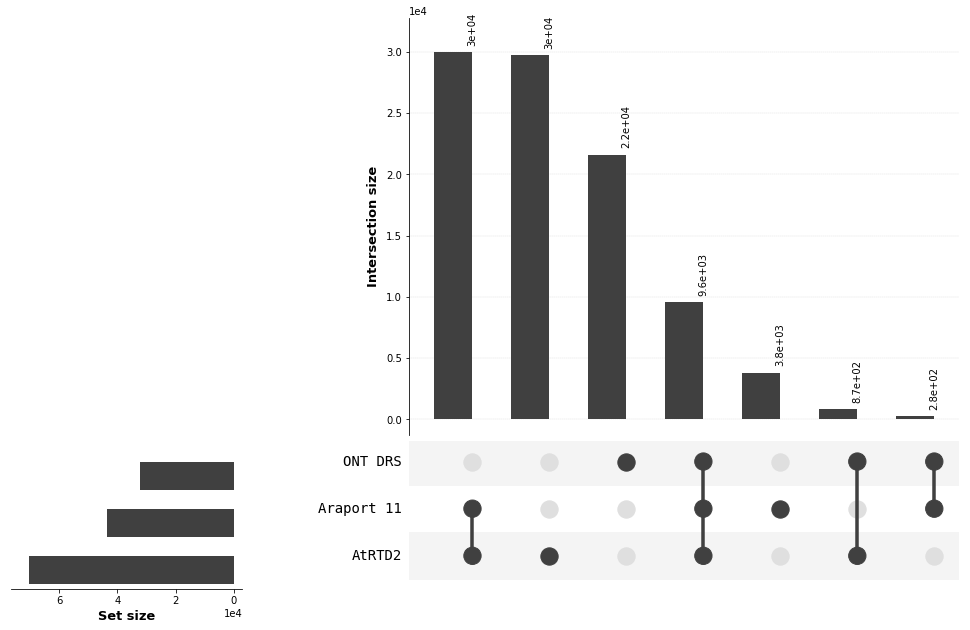

In [42]:
comp = {"ONT DRS":pd.DataFrame(list(drs_unique_spliceiso.keys())),
        "Araport 11":pd.DataFrame(list(a11_introns.keys())),
        "AtRTD2":pd.DataFrame(list(atrtd2_introns.keys()))}

upset = pyu.plot(comp, sort_by='size')
#                           query = [('ONT DRS', 'Illumina'),
#                                    ('ONT DRS', 'Araport 11'),
#                                    ('ONT DRS', 'AtRTD2'),
#                                    ('ONT DRS', 'Araport 11', 'AtRTD2'),
#                                    ('ONT DRS', 'Illumina', 'Araport 11', 'AtRTD2')])

In [43]:
# great, now lets get the exact numbers for these sets...
def extractColumnData(comparison):
    
    common_columns = []
    for i, k in enumerate(comparison.keys()):
        if i == 0:
            common_columns = comparison[k].columns
        else:
            common_columns = common_columns.intersection(comparison[k].columns)
            
    x = pyu.visualisation.DataExtractor(comparison, common_columns)   
    return(x)

def getSetCounts(comparison):
    
    x = extractColumnData(comparison)
    
    i=0
    while i<len(x.ordered_dfs):
        print("{:>15}: {:>6d}".format(x.ordered_df_names[i], len(x.ordered_dfs[i])))
        i+=1
    
    keypairs={}
    for key in x.inters_df_dict.keys():
        keypairs[len(x.inters_df_dict[key])] = " + ".join(key)
    
    for keypair in sorted(list(keypairs.keys())):
        print("{:>60}: {:>6d}".format(keypairs[keypair], keypair))

getSetCounts(comp)

         AtRTD2:  70202
     Araport 11:  43681
        ONT DRS:  32353
                                        Araport 11 + ONT DRS:    279
                                            AtRTD2 + ONT DRS:    872
                                                  Araport 11:   3815
                               AtRTD2 + Araport 11 + ONT DRS:   9573
                                                     ONT DRS:  21629
                                                      AtRTD2:  29730
                                         AtRTD2 + Araport 11:  30014


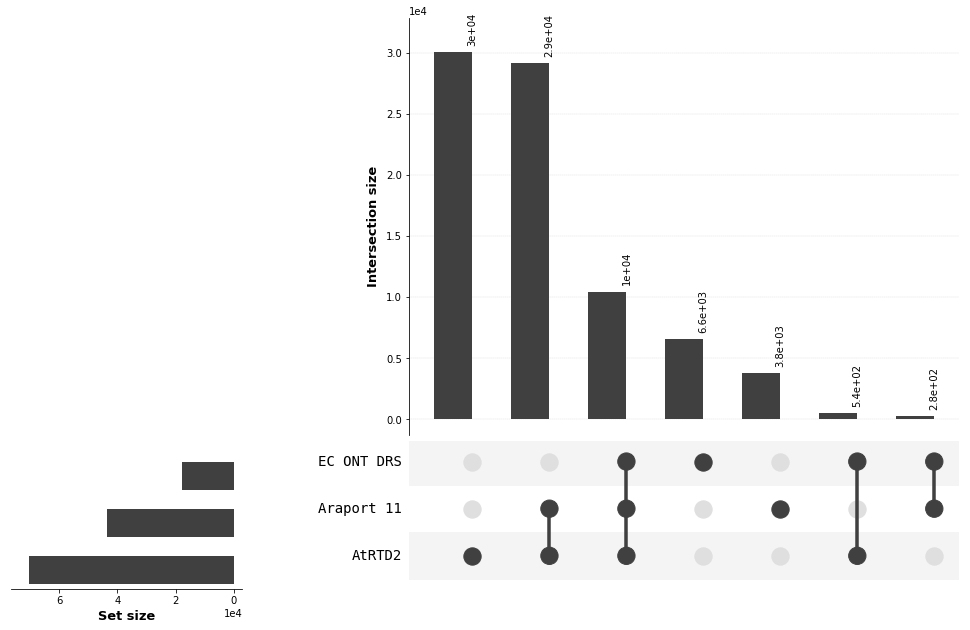

In [44]:
# now for the error corrected data
comp = {"EC ONT DRS":pd.DataFrame(list(ec_drs_unique_splicesiso.keys())),
        "Araport 11":pd.DataFrame(list(a11_introns.keys())),
        "AtRTD2":pd.DataFrame(list(atrtd2_introns.keys()))}

upset = pyu.plot(comp, sort_by='size')

In [45]:
getSetCounts(comp)

         AtRTD2:  70202
     Araport 11:  43681
     EC ONT DRS:  17848
                                     Araport 11 + EC ONT DRS:    281
                                         AtRTD2 + EC ONT DRS:    537
                                                  Araport 11:   3816
                                                  EC ONT DRS:   6576
                            AtRTD2 + EC ONT DRS + Araport 11:  10454
                                         AtRTD2 + Araport 11:  29130
                                                      AtRTD2:  30072


OK, now lets do the four-set comparison. Here we are going to highlight sets where the uncorrected DRS data has support, sets where the error-corrected data has support, and sets where the uncorrected and corrected datasets agree. This is to try and visualize the glocal pattern changes caused by the error correction.

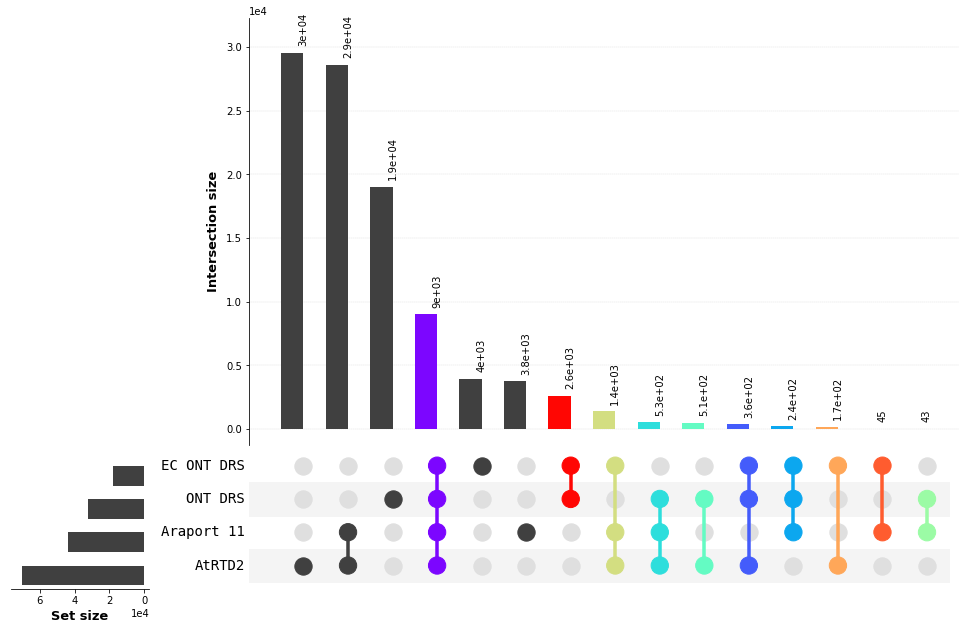

In [75]:
# now for the error corrected data
comp = {"ONT DRS":pd.DataFrame(list(drs_unique_spliceiso.keys())),
        "EC ONT DRS":pd.DataFrame(list(ec_drs_unique_splicesiso.keys())),
        "Araport 11":pd.DataFrame(list(a11_introns.keys())),
        "AtRTD2":pd.DataFrame(list(atrtd2_introns.keys()))}

upset = pyu.plot(comp, sort_by='size',
                query = [('ONT DRS', 'EC ONT DRS', 'Araport 11',  'AtRTD2'),
                         ('ONT DRS', 'EC ONT DRS',  'AtRTD2'),
                         ('ONT DRS', 'EC ONT DRS', 'Araport 11'),
                         ('ONT DRS', 'Araport 11',  'AtRTD2'),
                         ('ONT DRS', 'AtRTD2'),
                         ('ONT DRS', 'Araport 11'),
                         ('EC ONT DRS', 'Araport 11',  'AtRTD2'),
                         ('EC ONT DRS',  'AtRTD2'),
                         ('EC ONT DRS', 'Araport 11'),
                         ('ONT DRS', 'EC ONT DRS')])

plt.savefig("../figures/Figure_09.png", dpi=300, transparent=True, format='png')
plt.savefig("../figures/Figure_09.svg", format="svg")

In [48]:
getSetCounts(comp)

         AtRTD2:  70202
     Araport 11:  43681
        ONT DRS:  32353
     EC ONT DRS:  17848
                                        Araport 11 + ONT DRS:     43
                                     Araport 11 + EC ONT DRS:     45
                                         AtRTD2 + EC ONT DRS:    173
                           Araport 11 + EC ONT DRS + ONT DRS:    236
                               AtRTD2 + EC ONT DRS + ONT DRS:    364
                                            AtRTD2 + ONT DRS:    508
                               AtRTD2 + Araport 11 + ONT DRS:    530
                            AtRTD2 + EC ONT DRS + Araport 11:   1411
                                        EC ONT DRS + ONT DRS:   2610
                                                  Araport 11:   3770
                                                  EC ONT DRS:   3966
                  AtRTD2 + EC ONT DRS + Araport 11 + ONT DRS:   9043
                                                     ONT DRS:  19019
       

# Calculating some set numbers for the paper...

Lets start by calculating the number of unique splices in the ONT DRS data that are also in either annotation...

In [54]:
def getOrigCountMatchingKey(keyName, comparison):

    vals = extractColumnData(comparison)
    count=0
    for key in vals.inters_df_dict.keys():
        if 'ONT DRS' in key and keyName in key:
            count+=len(vals.inters_df_dict[key])
    
    acount = len(vals.ordered_dfs[numpy.where(vals.ordered_df_names==keyName)[0][0]])
    print("Unique splices in ONT DRS and in {}: {} ({:.2f}%)".format(keyName, count, 100*float(count)/acount))

getOrigCountMatchingKey('Araport 11', comp)

Unique splices in ONT DRS and in Araport 11: 9852 (22.55%)


In [55]:
getOrigCountMatchingKey('AtRTD2', comp)

Unique splices in ONT DRS and in AtRTD2: 10445 (14.88%)


In [71]:
def getMatchAnnot(comparison, datasetname):
    count=0
    vals = extractColumnData(comparison)
    for key in vals.inters_df_dict.keys():
        if datasetname in key and ('Araport 11' in key or 'AtRTD2' in key):
            count+=len(vals.inters_df_dict[key])

    totdrs=len(vals.ordered_dfs[int(numpy.where(numpy.array(vals.ordered_df_names)==datasetname)[0])])
    print("Unique splices in {} and either annotation: {} ({:.2f}% of {})".format(datasetname,
                                                                                  count,
                                                                                  100*float(count)/totdrs,
                                                                                  totdrs))
getMatchAnnot(comp, "ONT DRS")

Unique splices in ONT DRS and either annotation: 10724 (33.15% of 32353)


In [72]:
getMatchAnnot(comp, "EC ONT DRS")

Unique splices in EC ONT DRS and either annotation: 11272 (63.16% of 17848)


In [78]:
count = 2610
totdrs = 32353
totecdrs = 17848
print("Novel DRS splices that aren't impacted by error-correction: {} ({:.2f}% of {}) ({:.2f}% of {})" \
      "".format(count,100*float(count)/totdrs,totdrs,100*float(count)/totecdrs,totecdrs))

Novel DRS splices that aren't impacted by error-correction: 2610 (8.07% of 32353) (14.62% of 17848)


In [79]:
float(17848)/32353

0.5516644515191791

In [80]:
63.16+14.62

77.78